# Imports 

- No user input required

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score,cross_validate
from logreg_stats import calc_mcfad, calc_mcfadden_R2, precision_recall_f1_score, test_accuracy_score, kfold_logreg 
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
import warnings
warnings.filterwarnings("ignore")
randomstate = 42
import Logistic_Regression as fsc

# Define Plotting Functions
## Define plotting function for one-parameter logistic regression

- No user input required

In [3]:
def plot_fit_1D(feat, df_combined, save_fig=False):  
    X_train = np.array(df_combined.loc[:, [feat]])
    y_train = np.array(df_combined.iloc[:, -1])
    lr = LogisticRegression().fit(X_train,y_train)
    m, b = lr.coef_[0][0], lr.intercept_[0]
    feat_name = X_labelname_dict[feat]

    x_min, x_max = min(X_train), max(X_train)
    x_range = x_max - x_min
    plot_min, plot_max = float(x_min-0.05*x_range), float(x_max+0.05*x_range)

    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=26) 
    plt.yticks(fontsize=26)
    plt.xlabel(feat_name,fontsize=26)
    plt.ylabel('Probability',fontsize=26)
    #plt.locator_params(axis='y', nbins=4)
    #plt.locator_params(axis='x', nbins=5)
    plt.axvline(x=(-b/m),alpha=1,c='black')
    plt.axvline(x=((np.log(3)-b)/m),alpha=1,c='black', linestyle = '--')
    plt.axvline(x=((np.log(1/3)-b)/m),alpha=1,c='black', linestyle = '--')
    plt.scatter(X_train, y_train, label="training", alpha=1,marker='o', c ='Blue', s=150  ,edgecolor='black')
    plt.xlim(plot_min, plot_max)
    plt.ylim(-.05, 1.05)

    x = np.linspace(x_min-0.4*x_range, x_max+0.4*x_range)
    f_x = np.exp(b + m*x)
    y_sigmoid = f_x/(f_x + 1)
    plt.plot(x, y_sigmoid, color = 'black')
    if save_fig:
        plt.savefig(feat + '.png', dpi=500)
    plt.show()

## Define plotting function for 2D logistic regression

- No user input required
- colormap_scheme, test_points, train_points, point_color, and point_size can be changed to adjust the appearance of the plot

In [59]:
colormap_scheme = 'RdBu'
test_points, train_points = 'X', 'o' # marker shape of test set ('*', <, >, x, X, o, O, b, d,. )
point_color = 'Greys'# 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
point_size = 100

def heatmap_logreg(feat1, feat2, df_train, df_test, model, annotate_test = False, annotate_train = False):  
    #Train model on features
    p1_vals = df_train.iloc[:, feat1]
    p2_vals = df_train.iloc[:, feat2]
    p1_vals_test = df_test.iloc[:, feat1]
    p2_vals_test = df_test.iloc[:, feat2]
    lr = LogisticRegression().fit(df_train.iloc[:,[feat1, feat2]],y_train)
    intercept = lr.intercept_[0]
    c1, c2 = lr.coef_[0][0], lr.coef_[0][1]
    p1, p2 = X_names[feat1], X_names[feat2]
    
    #Get max/min values for X and Y axes
    max_x, min_x = max(list(p1_vals) + list(p1_vals_test)), min(list(p1_vals) + list(p1_vals_test))
    max_y, min_y = max(list(p2_vals) + list(p2_vals_test)), min(list(p2_vals) + list(p2_vals_test))
    range_x, range_y = abs(max_x - min_x), abs(max_y - min_y)
    max_x_plt, min_x_plt = max_x + 0.1*range_x, min_x - 0.1*range_x
    max_y_plt, min_y_plt = max_y + 0.1*range_y, min_y - 0.1*range_y
    
    #heatmap code
    xx = np.linspace(min_x_plt, max_x_plt, 500)
    yy = np.linspace(min_y_plt, max_y_plt, 500)
    xx,yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]
   
    # Predict probabilities of full grid
    probas = lr.predict_proba(Xfull)
    
    plt.figure(figsize=(9.5,8))
    plt.xticks(fontsize=25, fontname = 'Helvetica') 
    plt.yticks(fontsize=25, fontname = 'Helvetica')
    plt.xlabel(p1,fontsize=25, fontname = 'Helvetica',labelpad=20)
    plt.ylabel(p2,fontsize=25, fontname = 'Helvetica', labelpad=20)
    
    heatmap = plt.imshow(
            probas[:,1].reshape((500, 500)), cmap=colormap_scheme, alpha = 0.5, extent=[min_x_plt, max_x_plt, min_y_plt, max_y_plt],interpolation='nearest', origin="lower"
        ,aspect='auto')
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Probability', size=25, fontname = 'Helvetica', labelpad=20)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=5)
    plt.scatter(p1_vals, p2_vals, label="training", alpha=1,marker='o', c = df_train.iloc[:, -1], cmap=point_color + '_r', s=200  ,edgecolor='black')
    plt.scatter(p1_vals_test, p2_vals_test, label="test", alpha=1,marker='X' , c = df_test.iloc[:, -1], cmap=point_color + '_r', s=200  ,edgecolor='black')
    #plt.colorbar()
    #cbar.set_label('yield %',rotation=90,size=22,labelpad=20)

    x = np.linspace(min_x - 0.1*range_x, max_x + 0.1*range_x)
    y = -(intercept/c2) - (c1/c2)*x
    y_75 = ((np.log(3)-intercept)/c2) - (c1/c2)*x    #
    y_25 = ((np.log(1/3)-intercept)/c2) - (c1/c2)*x
    plt.xlim([min_x - 0.1*range_x, max_x + 0.1*range_x])
    plt.ylim([min_y - 0.1*range_y, max_y + 0.1*range_y])

    plt.plot(x, y, color = 'black')
    plt.plot(x,y_75, color = 'black', linestyle = '--')
    plt.plot(x,y_25, color = 'black', linestyle = '--')
    
    if annotate_test == True:
        for i, txt in enumerate(VS):
            label_i = y_labels[txt]
            plt.annotate(label_i, (p1_vals_test[i], p2_vals_test[i]), fontsize='14', c = 'white')
    if annotate_train == True:
        for i, txt in enumerate(TS):
            label_i = y_labels[txt]
            plt.annotate(label_i, (p1_vals[i], p2_vals[i]), fontsize='14', c = 'white')
    plt.tight_layout()
    plt.savefig('Logistic_Regression.png', dpi=500)
    plt.show()

# Reading data
## Choosing input files

- Sets up script to import data and parameters from excel
- populate this cell based on the excel spreadsheet that you want to be read
- populate y_cut with threshold value

In [90]:
comp_file = 'Bisphosphine_Parameters' # parameter excel file name 
comp_sheet = "symm_adapt_lowconf" # parameter excel sheet name
num_par = 508 # number of parameters
par_start_col = 2  # 0-indexed, first column number with descriptor values
comp_num_samples = 1039 # Number of ligands in sheet
y_label_col_comp = 0 # 0-indexed, the number of the column with the ligand ids

exp_file = 'Example_rxn_data' # data excel file name
exp_sheet = 'Data' # data excel sheet name
exp_num_samples = 42 # include all the ligands, the empty rows will be removed later
response_col = 2 # 0-indexed, the column containing the experimental results
y_label_col_exp= 1 # 0-indexed, the number of the column with the ligand ids

y_cut = 20   # this sets the threshold value for 1/0 

## Sorting data

- Imports parameters and data and converts continuous data to binary data
- No user input required

In [91]:
# make pd df for the descriptors
compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))),engine='openpyxl')
compinp = compinp.drop(['smiles'],axis=1)
par_start_col = 1
compinp.index = compinp.index.map(str)

# make pd df for the experimental file
expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=2,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)),engine='openpyxl')

# names of the descriptors
X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])

# labels for descriptors e.g. x1, x2, x3... make list then take only selection for descriptors
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]

# removes names of the descriptors from compinp
compinp.drop(index=compinp.index[0],inplace=True)

# X_all = np array of descriptor values for all ligands
X_all = np.asarray(compinp[X_labels],dtype=np.float)

# np array of the ligand ids from the descriptor file
y_labels_comp = np.asarray(list(compinp.index),dtype=str)

# compnan = array of True/False designating if a ligand has a missing descriptor value(s) or not
# nan = not a number. isnan returns True if Nan, in this case for any value in a row (axis of 1 = row).
compnan = np.isnan(X_all).any(axis=1)

# compares the arrays, and keeps the sample in y_labels_comp/X_all if the corresponding value in ~compnan = True.
# ~ means it inverts True and False in compnan. This is removing any ligands missing descriptors.
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

# combines the labels and names of descriptors as a single value in a list e.g. "x1 Vmin_LP(P).Boltz" 
X_labelname = [" ".join(i) for i in zip(X_labels,X_names)]

# makes a dictionary with key of descriptor label, value of descriptor name
X_labelname_dict = dict(zip(X_labels,X_names))

# heading ('label') for the response column
resp_label = list(expinp.columns)[response_col-1]

# array of the experimental results
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)

# array of all the ligand ids in the experimental file (curated below to give ligands with results only)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

# array with True for experimental results present, False for none
mask_y = ~np.isnan(y)

# check if each value of y_labels_exp (ligand ids in exp file) is also in y_labels_comp (ligand ids in descriptor file),
# to give an array with True/False if a match is found (i.e. do we have the descriptors we need) 
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])

# compares the two arrays, if same value is True in both then value = True in mask, otherwise = False.
# i.e. does the ligand have an experimental result and descriptors
mask = mask_y&mask_X

# ligands_removed is a list of ligands that had zero-values
count = 0
ligands_removed = []
for i in list(mask):
    if not i:
        ligands_removed.append(y_labels_exp[count])
    count += 1

print("Number of entries in experimental file before removing empty cells: {}".format(len(y)))
print("Removing {} entries with empty cells".format(len(y)-sum(mask)))
print('Entries removed: ', ligands_removed)

# remove all nan values from y, leaving experimental results
y = y[np.array(mask)]

# Convert reaction data to binary 1/0 based on y_cut
y = np.array([1 if result > y_cut else 0 for result in y])

# cut y_labels to only have ids for ligands with results
y_labels = y_labels_exp[np.array(mask)]

# X = array of descriptor values for the ligands with experimental results
X = np.asarray(compinp.loc[y_labels],dtype=np.float)



verbose = True
if verbose:
    print("Shape of descriptors file for all ligands: {}".format(X_all.shape))
    print("Last three ids in the descriptor file: {}".format(y_labels_comp[-3:]))
    print("Shape of descriptors file for ligands with experimental results: {}".format(X.shape))
    print("Shape of results file results (only ligands with experimental results): {}".format(y.shape)) 
    print("Shape of results file labels (only ligands with experimental results): {}".format(y_labels.shape))
    print("First descriptor cell (for ligands with experimental results): {}".format(X[0,0]))
    print("Last descriptor cell (for ligands with experimental results):  {}".format(X[-1,-1]))
    print('Ligands with results:',y_labels)
    print(len(y),' Experimental results:', " : ", y)

Number of entries in experimental file before removing empty cells: 42
Removing 0 entries with empty cells
Entries removed:  []
Shape of descriptors file for all ligands: (1039, 553)
Last three ids in the descriptor file: ['682_1' '693_1' '513_1']
Shape of descriptors file for ligands with experimental results: (42, 553)
Shape of results file results (only ligands with experimental results): (42,)
Shape of results file labels (only ligands with experimental results): (42,)
First descriptor cell (for ligands with experimental results): -0.53115
Last descriptor cell (for ligands with experimental results):  358.9
Ligands with results: ['251_1' '251' '301_1' '305_1' '299' '192_1' '24_1' '24' '175' '306_1'
 '306' '18' '18_1' '500' '478' '475' '10_1' '302' '165_1' '505' '481_1'
 '480' '719' '178' '504' '177' '489_1' '489' '488_1' '722_1' '723_1'
 '725_1' '722' '723' '725' '12' '16' '383' '14' '14_1' '721' '721_1']
42  Experimental results:  :  [1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 

# Univariate correlations and feature/feature plotting

## Univariate Logistic Regression

- Runs univariate logistic regression for all parameters and creates a dataframe of models in decending order of mcfadden R2
- No user input required

In [92]:
from logreg_stats import calc_mcfad

results_1_param = pd.DataFrame(columns=['Model', 'Accuracy', 'McFadden_R2', 'Param_name', 'Threshold_Value'])

count = 0
for i in range(len(X_labels)):
    term = X_labels[i]
    X_sel = X[:, i].reshape(-1,1)
    lr = LogisticRegression().fit(X_sel,y)
    acc = round(lr.score(X_sel,y), 2)
    mcfad_r2 = round(calc_mcfad(X_sel, y), 2)
    m, b = lr.coef_[0][0], lr.intercept_[0]
    row_i = {'Model': term, 'Accuracy': acc, 'McFadden_R2': mcfad_r2, 'Param_name': X_labelname_dict[term], 'Threshold_Value': -b/m}
    results_1_param = results_1_param.append(row_i, ignore_index=True)

results_1_param = results_1_param.sort_values('McFadden_R2', ascending=False)
results_1_param.head(10)

,Model,Accuracy,McFadden_R2,Param_name,Threshold_Value
231,x232,0.71,0.35,NoPd_P2_NMR_min,294.865010
552,x553,0.74,0.33,pol,458.931379
388,x389,0.76,0.33,NE_7.0_Ang_max,37.512735
385,x386,0.79,0.33,SE_7.0_Ang_max,36.879629
238,x239,0.71,0.30,NoPd_aniso_P2_NMR_max,69.815591
389,x390,0.74,0.30,NE_7.0_Ang_avg,36.826118
239,x240,0.71,0.29,NoPd_aniso_P2_NMR_avg,66.561090
386,x387,0.74,0.29,SE_7.0_Ang_avg,36.057542
233,x234,0.71,0.29,NoPd_P2_NMR_avg,297.199053
549,x550,0.74,0.29,Vbur%_7.0_Ang,36.249620


## Plot top univariates

- prints top n models (n = num_plots)
- populate num_plots and skipfeatures

x386 SE_7.0_Ang_max. Threshold value 36.33
Accuracy: 81%
McFadden R2: 0.36


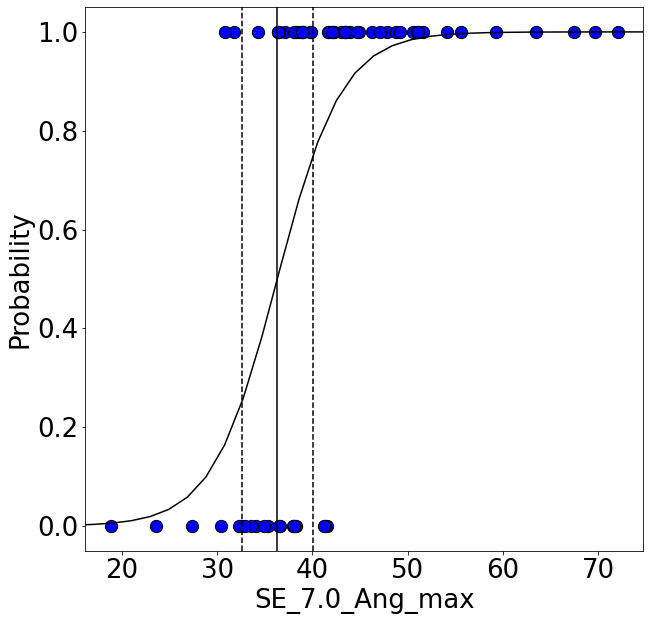




x550 Vbur%_7.0_Ang. Threshold value 36.01
Accuracy: 78%
McFadden R2: 0.34


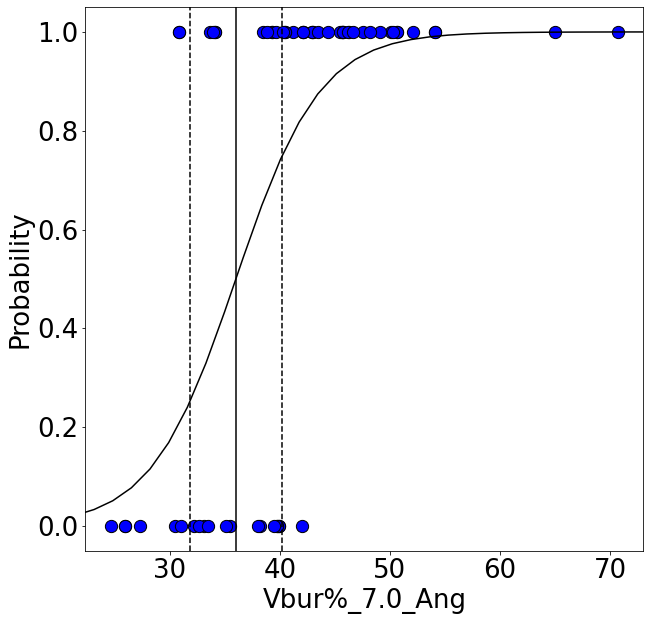




x553 pol. Threshold value 442.72
Accuracy: 79%
McFadden R2: 0.33


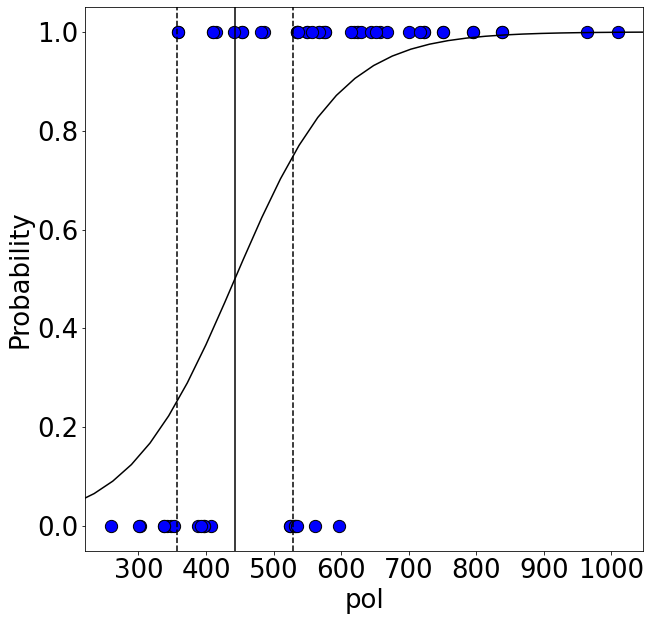




x387 SE_7.0_Ang_avg. Threshold value 35.60
Accuracy: 78%
McFadden R2: 0.33


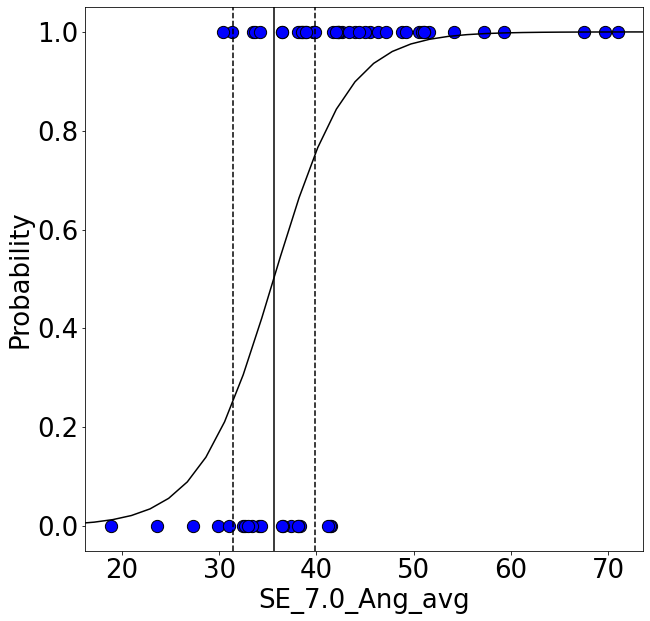




x389 NE_7.0_Ang_max. Threshold value 36.77
Accuracy: 76%
McFadden R2: 0.33


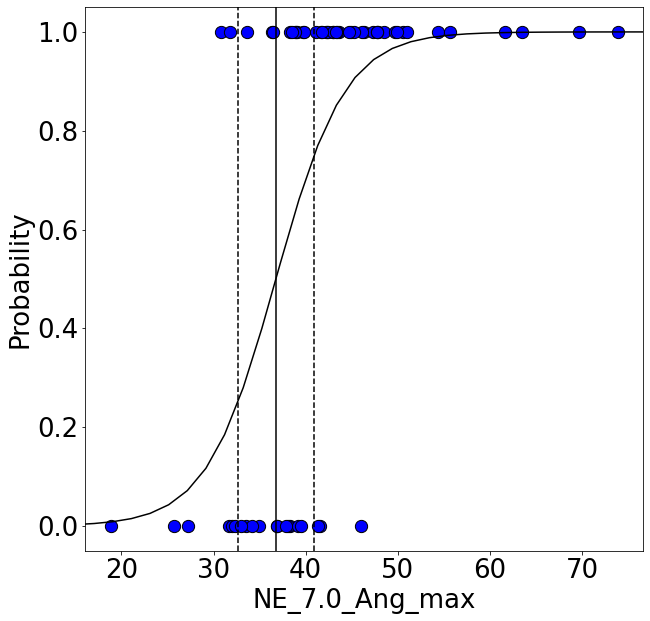

In [79]:
num_plots = 5  #Specify how many univariates to plot
skipfeatures = []  # add any features that you don't want to plot, e.g. ['x1', 'x3']


df_combined = pd.DataFrame(np.hstack((X,y[:,None]))) 
newcols = ["x"+str(i+1) for i in df_combined.columns.values]
df_combined.columns = newcols
response = newcols[-1]
df_combined.rename(columns={response:"y"},inplace=True)
df_combined.drop(skipfeatures,axis=1,inplace=True)

for i in range(num_plots):
    param_i = results_1_param.iloc[i].Model
    param_name = X_labelname_dict[param_i]
    threshold = results_1_param.iloc[i].Threshold_Value
    print("{} {}. Threshold value {:.2f}".format(param_i, param_name, threshold))
    print("Accuracy: {:.0f}%".format(100*results_1_param.iloc[i].Accuracy))
    print("McFadden R2: {}".format(results_1_param.iloc[i].McFadden_R2))
    plot_fit_1D(param_i, df_combined, save_fig=False)
    print("\n\n")

## Plot a univariate logistic regression with a user-defined parameter 

- Runs univariate logistic regression for user-defined parameter list
- Populate plot_params

x386 SE_7.0_Ang_max. Threshold value 36.88
Accuracy: 79%
McFadden R2: 0.33


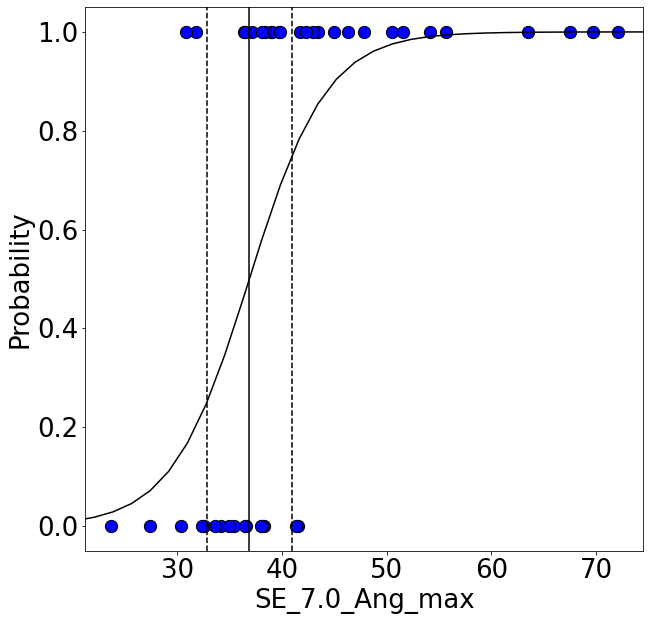




x552 dipole. Threshold value 12.35
Accuracy: 67%
McFadden R2: 0.13


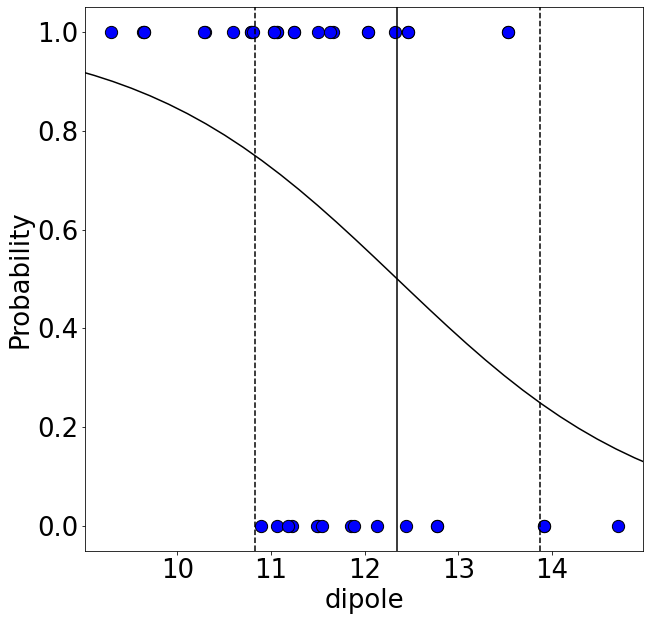

In [74]:
plot_params = ['x386','x240'] #populate with a list of parameters (e.g. plot_params = ['x1', 'x20', 'x21'])

for param_i in plot_params:
    row = results_1_param[results_1_param.Model == param_i]
    param_name = X_labelname_dict[param_i]
    threshold = float(row.Threshold_Value)
    acc = float(row.Accuracy)
    mcfad_r2 = float(row.McFadden_R2)
    print("{} {}. Threshold value {:.2f}".format(param_i, param_name, threshold))
    print("Accuracy: {:.0f}%".format(100*acc))
    print("McFadden R2: {}".format(mcfad_r2))
    plot_fit_1D(param_i,df_combined)
    print("\n\n")

## plot a feature vs. another feature

- plots one feature vs another to determine possible correlations
- Select two features to visualize (f_ind_1, f_ind_2)

x386 SE_7.0_Ang_max
x552 dipole

58 samples
R^2 = 0.07; p-value = 4.83E-02


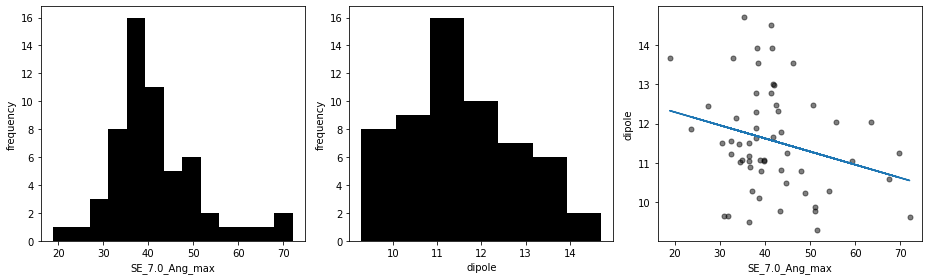

In [23]:
f_ind_1 = "x386" # feature of interest 1 (e.g. 'x1')
f_ind_2 = "x459" # feature of interest 1 (e.g. 'x120')

if type(f_ind_1) == str:
    [f_ind_1,f_ind_2] = [X_labels.index(i) for i in [f_ind_1,f_ind_2]]

print(X_labels[f_ind_1], X_names[f_ind_1])
print(X_labels[f_ind_2], X_names[f_ind_2])
print("\n{} samples".format(np.shape(X[:,f_ind_1])[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind_1],X[:,f_ind_2])
fit_line = intercept+slope*X[:,f_ind_1]
print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.hist(X[:,f_ind_1], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_1])
plt.subplot(1,3,2)
plt.hist(X[:,f_ind_2], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_2])

plt.subplot(1,3,3)
plt.scatter(X[:,f_ind_1], X[:,f_ind_2],color="black",marker=".",alpha=0.5,s=100)    
plt.plot(X[:,f_ind_1],fit_line)
plt.xlabel(X_names[f_ind_1])
plt.ylabel(X_names[f_ind_2])
plt.tight_layout()
plt.show()  
#plt.savefig("33.png",dpi=300)

# Data preparation

 - populate split and test_ratio

TS: [41, 18, 19, 10, 24, 33, 16, 29, 34, 6, 17, 28, 2, 12, 40, 27, 37, 23, 8, 22, 25, 36, 14, 1, 15, 4, 35, 21, 31, 32, 3, 30, 11]
VS: [5, 13, 7, 0, 39, 26, 9, 20, 38]
y_mean TS: 0.576
y_mean VS: 0.778
Shape X_train: (33, 553)
Shape X_test:  (9, 553)


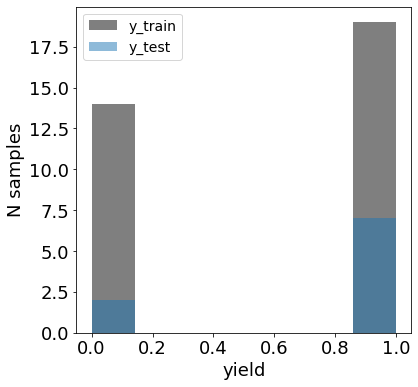

In [93]:
# Methods to split the data:
# 'random': randomly assigns train/test split
# 'define': give a list of ligand IDs for the training set (TS) and validation set (VS) in the corresponding code section.
# 'none': all samples in TS.

split = "random"  # use one of the methods outlined above
test_ratio = 0.2 # float from 0.0 to 1.0. Only relevant when split = 'random'

X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
    VS_IDS = ['103', '138_1', '353_1', '140', '23', '103_1', '45', '45_1', '199', '58_1', '362', '157', '285', '46', '470', '370', '80', '330', '377', '468', '364']
    TS_IDS = ['481_1', '251_1', '383', '721', '16', '178', '175', '306', '719', '14', '306_1', '14_1', '721_1', '478', '475', '251', '12', '301_1', '305_1', '299', '192_1', '24_1', '24', '18', '18_1', '500', '10_1', '302', '165_1', '505', '480', '504', '177', '489_1', '489', '488_1', '722_1', '723_1', '725_1', '722', '723', '725']
    VS = []
    TS = []
    for i in VS_IDS:
        try:
            num_i = expinp.index.get_loc(str(i))
        except:
            num_i = expinp.index.get_loc(int(i))
        VS.append(num_i)
    for i in TS_IDS:
        try:
            num_i = expinp.index.get_loc(str(i))
        except:
            num_i = expinp.index.get_loc(int(i))
        TS.append(num_i)
    print(VS, TS)
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
else: 
    raise ValueError("split option not recognized")
     
print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(6, 6))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
plt.legend(loc='best',fontsize=14)
plt.xlabel("yield",fontsize=18)
plt.ylabel("N samples",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Run Logistic Regression
## Prep data

- Prepares data for modelling (descriptors and results)
- populate skipfeatures with parameters that you don't want the model to evaluate

In [94]:
skipfeatures = []       # e.g. ["x4","x3"]
df_train = pd.DataFrame(np.hstack((X_train,y_train[:,None])))     
newcols = ["x"+str(i+1) for i in df_train.columns.values]
df_train.columns = newcols
response = newcols[-1]
df_train.rename(columns={response:"y"},inplace=True)
df_train.drop(skipfeatures,axis=1,inplace=True)


df_test = pd.DataFrame(np.hstack((X_test,y_test[:,None])))
newcols = ["x"+str(i+1) for i in df_test.columns.values]
df_test.columns = newcols
response = newcols[-1]
df_test.rename(columns={response:"y"},inplace=True)
df_test.drop(skipfeatures,axis=1,inplace=True)

## Manual selection of features

- Runs 2D logistic regression with user-defined parameters
- populate features_x, annotate_test_set, annotate_training_set

Parameters and coefficients:
   -3.2278 + 
    0.4262 * x386 SE_7.0_Ang_max
   -1.0799 * x552 dipole

McFadden Training R2  = 0.49
McFadden Test R2  = 0.71

Accuracy  = 75.8 %
Test Accuracy  = 100.0%

Training K-fold Accuracy = 80.79 (+/- 1.07) %
f1 Score  = 0.752
Precision Score  = 0.752
Recall Score  = 0.752

Note: 
(1) Black and white points denote active and inactive ligands respectively.
(2) Red and blue denote active and inactive chemical space respectively.
(3) Dashed lines denote 25% and 75% probability that a ligand will be active.
(4) Solid black line denotes 50% probability that a ligand will be active.


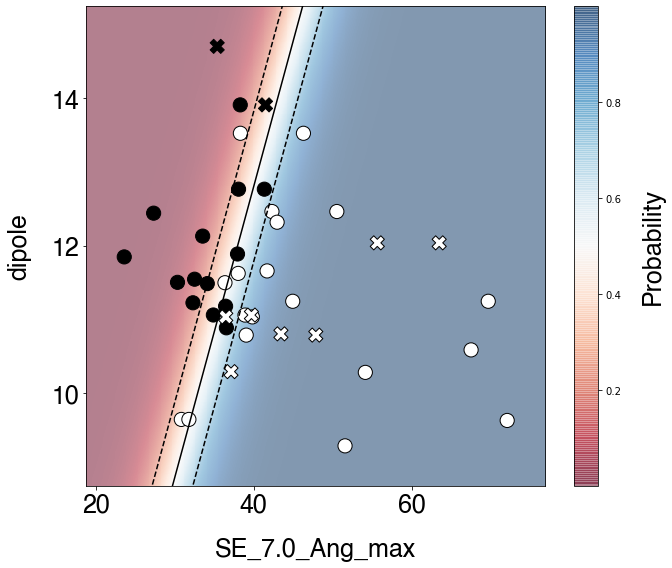

In [95]:
features_x = ('x386', 'x459') # tuple of features. eg ('x1', 'x10')
annotate_test_set = False    # set to True if you want to test set points labeled with ligand id 
annotate_training_set = False    # set to True if you want to training set points labeled with ligand id 


selected_feats = sorted([X_labels.index(i.strip()) for i in features_x])
X_train_sel = X_train[:,selected_feats]
X_test_sel = X_test[:,selected_feats]
lr = LogisticRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
if len(VS) > 0:  
    test_accuracy = test_accuracy_score(X_test_sel, y_test, X_train_sel, y_train)  
kfold_score, kfold_stdev = kfold_logreg(X_train_sel, y_train)
precision, recall, f1 = precision_recall_f1_score(X_train_sel, y_train)
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test)

print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_[0]) + "\n".join(["{:10.4f} * {}".format(lr.coef_[0][i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nMcFadden Training R2  = {train_R2 :.2f}")
if len(VS) > 0:
    print(f"McFadden Test R2  = {test_R2 :.2f}")
print(f"\nAccuracy  = {100 * lr.score(X_train_sel, y_train):.1f} %")
if len(VS) > 0:
    print(f"Test Accuracy  = {100 * lr.score(X_test_sel, y_test):.1f}%")
print("\nTraining K-fold Accuracy = {:.2f} (+/- {:.2f}) %".format(100* kfold_score, 100* kfold_stdev ** 2))
print(f"f1 Score  = {f1:.3f}")
print(f"Precision Score  = {precision :.3f}")
print(f"Recall Score  = {recall:.3f}")
print('\nNote: \n(1) Black and white points denote active and inactive ligands respectively.')
print('(2) Red and blue denote active and inactive chemical space respectively.')
print('(3) Dashed lines denote 25% and 75% probability that a ligand will be active.')
print('(4) Solid black line denotes 50% probability that a ligand will be active.')


heatmap_logreg(selected_feats[0],selected_feats[1],df_train,df_test,features_x, annotate_test=annotate_test_set, annotate_train=annotate_training_set)


##  Forward Stepwise Logistic Regression

- Runs logistic regression using all 2-parameter combinations (within collin_criteria)
- Populate collin_criteria

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 286.8845
Done. Time taken (minutes): 4.79


Model with the highest Accuracy:
1 + x199 + x238
1 + angle_R1P1RBack1_min + NoPd_aniso_P2_NMR_min

Parameters and coefficients:
  140.3222 + 
   -1.4785 * x199 angle_R1P1RBack1_min
    0.1816 * x238 NoPd_aniso_P2_NMR_min

McFadden Training R2  = 0.93
McFadden Test R2  = -2.99

Training Accuracy   = 100.000 %
Test Accuracy  = 66.7%

Training K-fold Accuracy = 91.90 (+/- 0.85) %
f1 Score  = 1.000
Precision Score  = 1.000
Recall Score  = 1.000


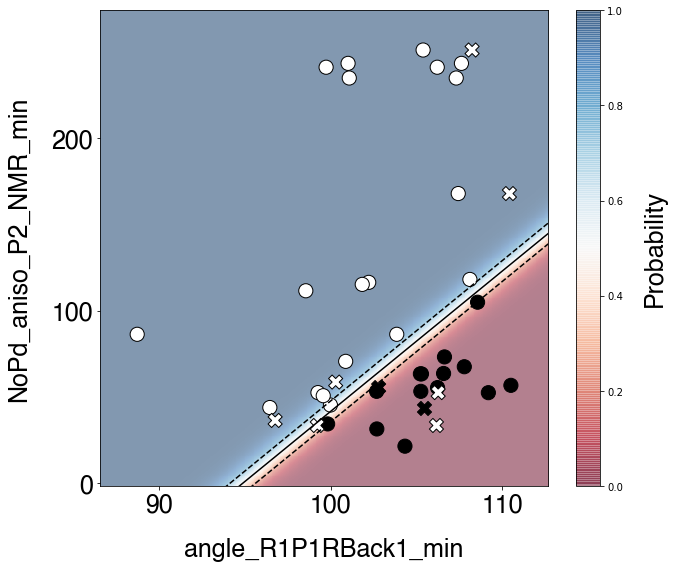

In [96]:
collin_criteria = 0.5   # the maximum allowed R2 between terms in a given model

# Runs forward stepwise model search
results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df_train,'y',
                    collin_criteria=collin_criteria)

# Identifies model with highest Accuracy
model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
print("\n\nModel with the highest Accuracy:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")

# Finds features used in best model for the training/test data, reruns lr, get statistics
X_train_sel = X_train[:,selected_feats]
X_test_sel = X_test[:,selected_feats]
lr = LogisticRegression()
lr.fit(X_train_sel,y_train)
kfold_score, kfold_stdev = kfold_logreg(X_train_sel, y_train)
precision, recall, f1 = precision_recall_f1_score(X_train_sel, y_train)
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test)

# Plots model and prints stats
print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_[0]) + "\n".join(["{:10.4f} * {}".format(lr.coef_[0][i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nMcFadden Training R2  = {train_R2 :.2f}")
if len(VS) > 0:
    print(f"McFadden Test R2  = {test_R2 :.2f}")
print(f"\nTraining Accuracy   = {100 * lr.score(X_train_sel, y_train):.3f} %")
if len(VS) > 0:  # This is False if no data was left out as a test set. 
    print(f"Test Accuracy  = {100 * lr.score(X_test_sel, y_test):.1f}%")
print("\nTraining K-fold Accuracy = {:.2f} (+/- {:.2f}) %".format(100* kfold_score, 100* kfold_stdev ** 2))
print(f"f1 Score  = {f1:.3f}")
print(f"Precision Score  = {precision :.3f}")
print(f"Recall Score  = {recall:.3f}")

if len(model_sel) > 1:
    heatmap_logreg(selected_feats[0],selected_feats[1],df_train,df_test,results.iloc[0][0])
else:
    print("The model with the highest accuracy is a 1-parameter model!")

## Display multiple models

- prints out the top n models in a dataframe
- populate within the results1.head() parenthesis

In [99]:
results['Param_1'] = results.Model.apply(lambda x: X_labelname_dict[x[0]])
results['Param_2'] = results.Model.apply(lambda x: X_labelname_dict[x[1]] if len(x) == 2 else "1-term")
results1 = results.sort_values('McFadden_R2', ascending=False)
results1 = results1.round(2)
results1 = results1[['Model', 'Accuracy', 'McFadden_R2', 'Param_1', 'Param_2', 'n_terms']]

results1.head(10) # put the number of models you want displayed in the parenthesis


,Model,Accuracy,McFadden_R2,Param_1,Param_2,n_terms
2,"(x199, x240)",1.00,0.93,angle_R1P1RBack1_min,NoPd_aniso_P2_NMR_avg,2
0,"(x199, x238)",1.00,0.93,angle_R1P1RBack1_min,NoPd_aniso_P2_NMR_min,2
1,"(x199, x239)",1.00,0.93,angle_R1P1RBack1_min,NoPd_aniso_P2_NMR_max,2
10,"(x199, x232)",0.94,0.88,angle_R1P1RBack1_min,NoPd_P2_NMR_min,2
9,"(x24, x199)",0.97,0.84,P2_NMR_avg,angle_R1P1RBack1_min,2
5,"(x22, x199)",0.97,0.84,P2_NMR_min,angle_R1P1RBack1_min,2
3,"(x199, x234)",0.97,0.83,angle_R1P1RBack1_min,NoPd_P2_NMR_avg,2
13,"(x201, x239)",0.94,0.79,angle_R1P1RBack1_avg,NoPd_aniso_P2_NMR_max,2
14,"(x201, x240)",0.94,0.79,angle_R1P1RBack1_avg,NoPd_aniso_P2_NMR_avg,2
8,"(x231, x232)",0.97,0.78,NoPd_P1_NMR_avg,NoPd_P2_NMR_min,2


In [100]:
# This cell will print all models with a given parameter

interest_param = 'SE_7.0_Ang_max'
results2 = results1[(results1.Param_1 == interest_param)| (results1.Param_2 == interest_param)]
results2.head(20)

,Model,Accuracy,McFadden_R2,Param_1,Param_2,n_terms
1034,"(x232, x386)",0.85,0.67,NoPd_P2_NMR_min,SE_7.0_Ang_max,2
1175,"(x234, x386)",0.85,0.59,NoPd_P2_NMR_avg,SE_7.0_Ang_max,2
1281,"(x240, x386)",0.85,0.55,NoPd_aniso_P2_NMR_avg,SE_7.0_Ang_max,2
88,"(x386, x406)",0.91,0.54,SE_7.0_Ang_max,SW_octant_3.0_Ang_min,2
3261,"(x239, x386)",0.82,0.54,NoPd_aniso_P2_NMR_max,SE_7.0_Ang_max,2
3177,"(x238, x386)",0.82,0.54,NoPd_aniso_P2_NMR_min,SE_7.0_Ang_max,2
2958,"(x233, x386)",0.82,0.53,NoPd_P2_NMR_max,SE_7.0_Ang_max,2
6762,"(x22, x386)",0.79,0.53,P2_NMR_min,SE_7.0_Ang_max,2
8227,"(x29, x386)",0.79,0.52,aniso_P2_NMR_max,SE_7.0_Ang_max,2
15232,"(x335, x386)",0.76,0.51,NoPd_LP_P2_s_max,SE_7.0_Ang_max,2


## Visualize a specific model

- Prints plot and statistics for a model of interest
- populate model number with the index of the model that you want to plot
- populate annotate_train and annotate test

(note that this only plots models that are within the results1 dataframe)

Parameters and coefficients:
   -3.2278 + 
    0.4262 * x386 SE_7.0_Ang_max
   -1.0799 * x552 dipole

McFadden Training R2  = 0.49
McFadden Test R2  = 0.71

Accuracy  = 75.8 %
Test Accuracy  = 100.0%

Training K-fold Accuracy = 80.79 (+/- 1.07) %
f1 Score  = 0.752
Precision Score  = 0.752
Recall Score  = 0.752

Note: 
(1) Black and white points denote active and inactive ligands respectively.
(2) Red and blue denote active and inactive chemical space respectively.
(3) Dashed lines denote 25% and 75% probability that a ligand will be active.
(4) Solid black line denotes 50% probability that a ligand will be active.


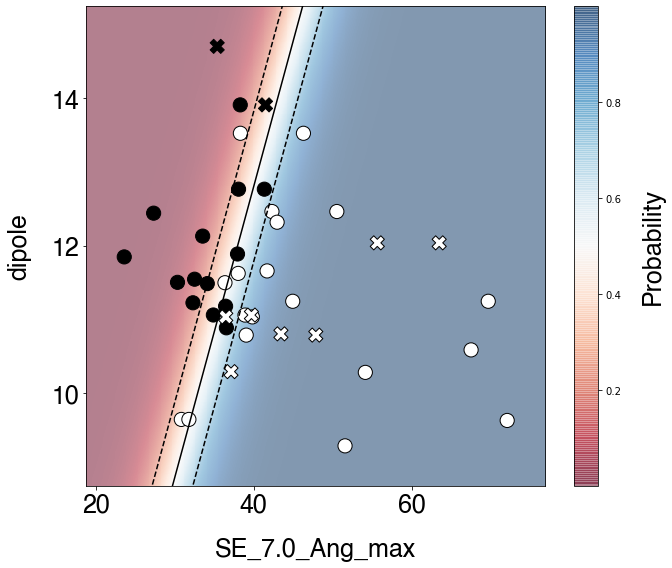

In [101]:
model_number = 16023
annotate_test_set = False    # set to True if you want test set points labeled with ligand ID
annotate_training_set = False    # set to True if you want training set points labeled with ligand ID

model_sel = results.loc[model_number,"Model"]

selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train[:,selected_feats]
X_test_sel = X_test[:,selected_feats]
lr = LogisticRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
if len(VS) > 0:  
    test_accuracy = test_accuracy_score(X_test_sel, y_test, X_train_sel, y_train)  
kfold_score, kfold_stdev = kfold_logreg(X_train_sel, y_train)
precision, recall, f1 = precision_recall_f1_score(X_train_sel, y_train)
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test)

print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_[0]) + "\n".join(["{:10.4f} * {}".format(lr.coef_[0][i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nMcFadden Training R2  = {train_R2 :.2f}")
if len(VS) > 0:
    print(f"McFadden Test R2  = {test_R2 :.2f}")
print(f"\nAccuracy  = {100 * lr.score(X_train_sel, y_train):.1f} %")
if len(VS) > 0:
    print(f"Test Accuracy  = {100 * lr.score(X_test_sel, y_test):.1f}%")
print("\nTraining K-fold Accuracy = {:.2f} (+/- {:.2f}) %".format(100* kfold_score, 100* kfold_stdev ** 2))
print(f"f1 Score  = {f1:.3f}")
print(f"Precision Score  = {precision :.3f}")
print(f"Recall Score  = {recall:.3f}")
print('\nNote: \n(1) Black and white points denote active and inactive ligands respectively.')
print('(2) Red and blue denote active and inactive chemical space respectively.')
print('(3) Dashed lines denote 25% and 75% probability that a ligand will be active.')
print('(4) Solid black line denotes 50% probability that a ligand will be active.')


heatmap_logreg(selected_feats[0],selected_feats[1],df_train,df_test,results.iloc[model_number][0], 
               annotate_test=annotate_test_set, annotate_train=annotate_training_set)



# Virtual screening

## Setup

- Re-makes descriptors dataframe and combines training and test sets
- No user input required

In [102]:
ci = pd.read_excel(comp_file+'.xlsx', comp_sheet,index_col=0,header=1,engine='openpyxl')
X_all_names = np.array(ci.Ligand)
compinp = ci[ci.columns[1:]].loc[ci.index[:]]
compinp.dropna(axis=0,inplace=True)
X_all = np.array(compinp)
X_all_ids = np.array(compinp.index)

# add all of the results to the training set
print('Number of samples in original training set = ',len(y_train))
y_train = np.concatenate((y_train,y_test), axis=0)
X_train = np.concatenate((X_train,X_test), axis=0)
print('Number of samples in updated training set = ',len(y_train))

X_screen = X_all
X_ids = X_all_ids.astype(str)
X_names = X_all_names

Number of samples in original training set =  33
Number of samples in updated training set =  42


## Virtually screen using a single (retrained) model

- Virtually screens all new ligands using a selected model 
- populate use_model

In [103]:
use_model = 16023 # index of model you want to use from results1 (int)
model_sel = results.loc[use_model,"Model"] # choose the model

# collect the model features for the training and screening sets 
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train[:,selected_feats]
X_screen_sel = X_screen[:,selected_feats]

# perform lr on training set, then use model to predict training set (for R2) and screening set - gives points on the line
lr = LogisticRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict_proba(X_train_sel)[:,1]
y_pred_screen =  lr.predict_proba(X_screen_sel)[:,1]

# Pull McFadden R2 
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test) # note that test_R2 here is a meaningless number
print(f"\nMcFadden R2  = {train_R2 :.2f}")



McFadden R2  = 0.56


## Plot the virtual screening results with the visualized model

- plots a histogram of virtual screening probabilities
- populate savefig

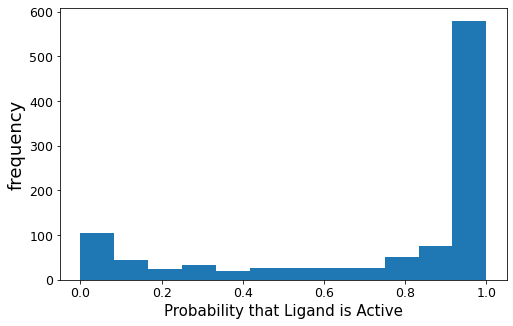

In [104]:
savefig = True # True if you want to save the virtual screen histogram as a png

X_combined = []
for i in range(0,len(X_ids)):
    j = str(X_names[i]) + " (ID " + X_ids[i] + ")"
    X_combined.append(j)
    
plt.figure(figsize=(8,5))
plt.xticks(fontsize=12.5) 
plt.yticks(fontsize=12.5)
plt.xlabel("Probability that Ligand is Active",fontsize=15)
plt.hist(y_pred_screen, bins="auto")
plt.ylabel("frequency",fontsize=18)

if savefig:
    plt.savefig("virtual_screen.png",dpi=200)

plt.show()


## Create table of virtual screening results with the visualized model

In [105]:
df = pd.DataFrame(list(zip(X_combined, y_pred_screen)), columns = ['Ligand','Predicted_probability']).sort_values('Predicted_probability', ascending=False)
df1 = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df1.set_properties(**{'text-align': 'center'}).hide_index()
df.to_excel('Predictions.xlsx', index = True)
df.head(10)



,Ligand,Predicted_probability
604,SS-Benzobisdiazaphos (ID 472),1.0
166,R-DTBM-BIPHUP (ID 253),1.0
228,R-DTBM-Difluorophos (ID 186),1.0
562,SS-Bisdiazaphos (ID 476),1.0
70,DiPrM-BIPHUP (ID 283),1.0
860,M000-1-IPDA_ENANT (ID 520_1),1.0
589,M000-1-IPDA (ID 520),1.0
1018,M000-1-TMS_ENANT (ID 525_1),1.0
870,SS-Benzobisdiazaphos_ENANT (ID 472_1),1.0
705,RRS-Bisdiazaphos (ID 475),1.0
